# Plotting the maximum radius and corresponding P_ZAMS

When computing the formation efficiency, one factor that comes into play is the range of periods of stars that interact

To estimate this, I want to plot the maximum radius of stars at different metallicities for a typical BH and NS progenitor star, and then plot the corresponging P_ZAMS 

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import h5py as h5
from matplotlib.colors import ListedColormap
from astropy.table import Table

from astropy import constants as const
from astropy import units as u

home_dir = os.path.expanduser("~")

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,18,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
sim_name        = "OldWinds_RemFryer2012" # sim_name determines which flags to run COMPAS with
root_out_dir    = f"/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/{sim_name}"


# Load the Single star grid data

In [3]:
# Mapping types to names 
Stellar_Type_table = Table()
Stellar_Type_table['types'] = ['MS_low', 'MS' ,'HG', 'AGB', 'CHeB', 'EAGB','TPAGB','HeMS','HeHG','HeGB','HeWD','COWD','ONeWD','NS','BH','massless remnant']
Stellar_Type_table['indices'] = np.arange(len(Stellar_Type_table))

# NEW mass loss types
Wind_prescr_table = Table()
Wind_prescr_table['types'] = ['NONE', 'OB', 'VMS', 'GB', 'RSG', 'WR', 'LBV']
Wind_prescr_table['indices'] = np.arange(len(Wind_prescr_table))

# # Old mass loss types
# Wind_prescr_table = Table()
# Wind_prescr_table['types'] = ['None', 'Nieuwenhuijzen and de Jager', 'Kudritzki and Reimers', 'Vassiliadis and Wood', 'Wolf-Rayet-like (Hamann, Koesterke and de Koter)', 'Vink', 'Luminous Blue Variable']
# Wind_prescr_table['indices'] = np.arange(len(Wind_prescr_table))


def get_max_radii(loc = '{root_out_dir}/SingleStarGrids/SingleStars_M10/'):
    Metals, maxRadii, maxR_type, maxR_massloss    = [],  [],  [],  []

    for i in range(100):
        # Read detailed hdf5 file
        detailed_data = f'{loc}/Detailed_Output/BSE_Detailed_Output_{i}.h5'
        detailh5 = h5.File(detailed_data, 'r')

        # Get the relevant info out
        i_maxR = np.argmax(detailh5['Radius(1)'][()])
        Metals.append(detailh5['Metallicity@ZAMS(1)'][0])
        maxRadii.append( detailh5['Radius(1)'][i_maxR] )
        maxR_type.append(detailh5['Stellar_Type(1)'][i_maxR])   
        maxR_massloss.append(detailh5['Dominant_Mass_Loss_Rate(1)'][i_maxR])

        maxR_RL1 = np.max(detailh5['Radius(1)'][()]/detailh5['RocheLobe(1)'][()]) 
        if maxR_RL1 > 1.0:
            print(f'Watch out!RL1: {maxR_RL1} for {i}')
        maxR_RL2 = np.max(detailh5['Radius(2)'][()]/detailh5['RocheLobe(2)'][()]) 
        if maxR_RL2 > 1.0:
            print(f'Watch out! RL2: {maxR_RL2} for {i}')
    return Metals, maxRadii, maxR_type, maxR_massloss

In [4]:
# Initialize an empty dictionary
data = {
    'M0': [],
    'Metals': [],
    'maxRadii': [],
    'maxR_type': [],
    'maxR_massloss': [],
    #
    'R_ZAMS': [],
    'maxR_MS': [],
    'maxR_HG': [],
    'maxR_FGB': [],
    'maxR_CHeB': [],
    'maxR_EAGB': [],
    #
    'Luminosity': [],
    'Teff': [],
    'Radius': [],
    'Mass': [],
    'Stellar_Type': [],
    'Dominant_Wind': []
}

# For each mass, compute the values and append them to the lists
for mass in [10, 20, 30, 40, 50, 60, 70,90, 100, 150]:
    print('mass', mass)

    read_loc =  f'{root_out_dir}/SingleStarGrids/SingleStars_M{mass}/'

    print('reading ', read_loc)
    
    try:
        Metals, maxRadii, maxR_type, maxR_massloss   = [],  [],  [],  []
        R_ZAMS, maxR_MS, maxR_HG, maxR_FGB, maxR_CHeB, maxR_EAGB = [], [], [], [], [], []
        L, Teff, M, Radius, stellar_type, dominant_wind = [], [], [], [], [], []

        for i in range(100):
            # Read detailed hdf5 file
            detailh5 = h5.File(f'{read_loc}/Detailed_Output/BSE_Detailed_Output_{i}.h5', 'r')

            ####################################### 
            # Maximum radius at all times
            i_maxR = np.argmax(detailh5['Radius(1)'][()])
            Metals.append(detailh5['Metallicity@ZAMS(1)'][0])
            maxRadii.append( detailh5['Radius(1)'][i_maxR] )
            maxR_type.append(detailh5['Stellar_Type(1)'][i_maxR])   
            maxR_massloss.append(detailh5['Dominant_Mass_Loss_Rate(1)'][i_maxR])

            #######################################
            # Select the maximum radius for each stellar type
            R_ZAMS.append(detailh5['Radius(1)'][0])

            st1 = detailh5['Stellar_Type(1)'][()]
            MS_bool = np.logical_or(st1 == 0, st1 == 1)
            maxR_MS.append(max(detailh5['Radius(1)'][MS_bool]) )

            HG_bool = st1 == 2
            maxR_HG.append(max(detailh5['Radius(1)'][HG_bool]) if np.any(HG_bool) > 0 else 0)

            FGB_bool = st1 == 3
            maxR_FGB.append(max(detailh5['Radius(1)'][FGB_bool]) if np.any(FGB_bool) > 0 else 0)
            
            CHeB_bool = st1 == 4
            maxR_CHeB.append(max(detailh5['Radius(1)'][CHeB_bool]) if np.any(CHeB_bool) > 0 else 0 )

            EAGB_bool = st1 == 5
            maxR_EAGB.append(max(detailh5['Radius(1)'][EAGB_bool]) if np.any(EAGB_bool) > 0 else 0 )

            #######################################
            # For HR diagram
            L.append(detailh5['Luminosity(1)'])
            Teff.append(detailh5['Teff(1)'])
            Radius.append(detailh5['Radius(1)'])
            M.append(detailh5['Mass(1)'])
            stellar_type.append(detailh5['Stellar_Type(1)'])
            dominant_wind.append(detailh5['Dominant_Mass_Loss_Rate(1)'])

            maxR_RL1 = np.max(detailh5['Radius(1)'][()]/detailh5['RocheLobe(1)'][()]) 
            if maxR_RL1 > 1.0:
                print(f'Watch out! maxR_RL1: {maxR_RL1} for {i}')
            maxR_RL2 = np.max(detailh5['Radius(2)'][()]/detailh5['RocheLobe(2)'][()]) 
            if maxR_RL2 > 1.0:
                print(f'Watch out! maxR_RL2: {maxR_RL2} for {i}')
                    
        # Max R
        data['M0'].append(mass)
        data['Metals'].append(Metals)
        data['maxRadii'].append(maxRadii)
        data['maxR_type'].append(maxR_type)
        data['maxR_massloss'].append(maxR_massloss)

        # Max R per type
        data['R_ZAMS'].append(R_ZAMS)
        data['maxR_MS'].append(maxR_MS)
        data['maxR_HG'].append(maxR_HG)
        data['maxR_FGB'].append(maxR_FGB)
        data['maxR_CHeB'].append(maxR_CHeB)
        data['maxR_EAGB'].append(maxR_EAGB)

        # HR
        data['Luminosity'].append(L)
        data['Teff'].append(Teff)   
        data['Radius'].append(Radius)  
        data['Mass'].append(M)  
        data['Stellar_Type'].append(stellar_type)  
        data['Dominant_Wind'].append(dominant_wind)  

    except Exception as e:
        print('ERR:', e)
        traceback.print_exc()
        continue


print(data['M0'])

mass 10
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M10/
mass 20
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M20/
mass 30
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M30/
mass 40
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M40/
mass 50
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M50/
mass 60
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M60/
mass 70
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M70/
mass 90
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M90/
mass 100
reading  /mnt/home/lvanson/ceph/CompasOutput/v0

mass 10 0


/tmp/ipykernel_3394886/3848019753.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")


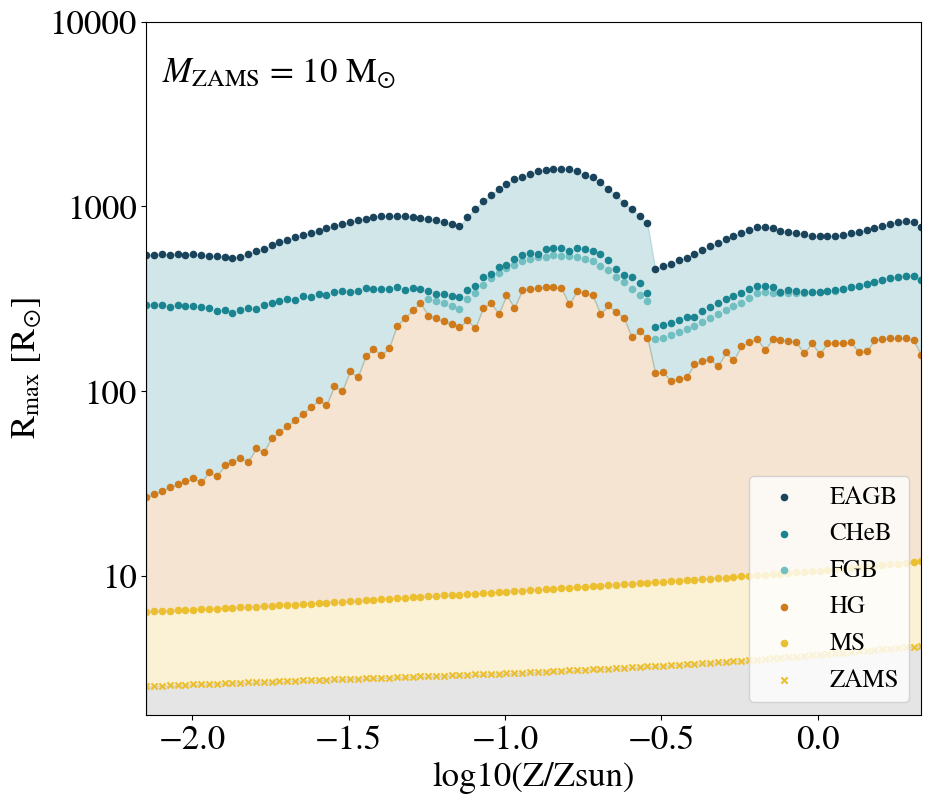

mass 40 3


/tmp/ipykernel_3394886/3848019753.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_3394886/3848019753.py:35: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")


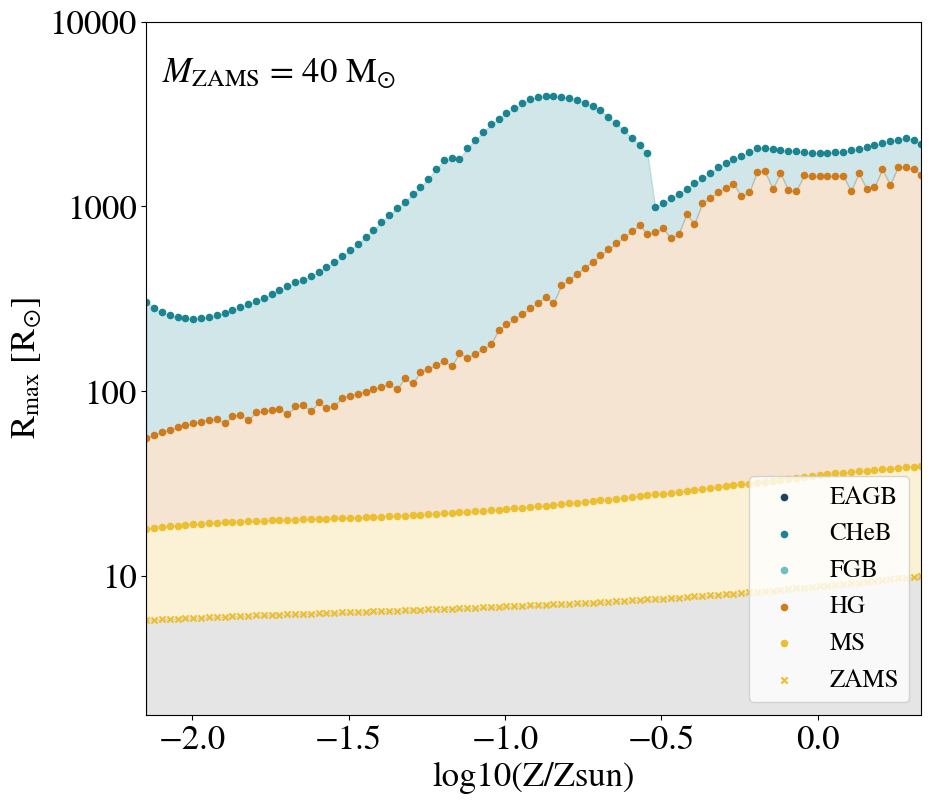

In [9]:


def plot_maxR_CaseABC(mass):
    """
    Plot the maximum radius for each type of star as a function of metallicity
    """
    mi = data['M0'].index(mass)
    print('mass', mass, mi)

    fig, ax = plt.subplots(figsize =(10,9))

    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 =0, y2 = np.log10(data['R_ZAMS'][mi]),  color = 'grey', alpha = 0.2)

    # R_ZAMS
    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['R_ZAMS'][mi]), c = '#ebbf2f', s = 20, marker = 'x', label = 'ZAMS')

    # Case A is up to max MS
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(data['R_ZAMS'][mi]), y2 = np.log10(data['maxR_MS'][mi]),  color = '#ebbf2f', alpha = 0.2)

    #Case B is between MS and HG 
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(data['maxR_MS'][mi]), y2 = np.log10(data['maxR_HG'][mi]),  color = '#cf7b1b', alpha = 0.2)

    # Case C is beyond HG
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(data['maxR_HG'][mi]), y2 = np.log10(data['maxRadii'][mi]),  color = '#1a8591', alpha = 0.2)

    # Per types
    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_MS'][mi]), c = '#ebbf2f', s = 20, label = 'MS')

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_HG'][mi]), c = "#cf7b1b", s = 20, label = "HG")

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
    # plt.plot(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", lw = 2, label = None)

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_CHeB'][mi]), c = "#1a8591", s = 20, label = "CHeB")
    # plt.plot(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_CHeB'][mi]), c = "#1a8591", lw = 2, label = None)

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")
    # plt.plot(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", lw = 4, label = None)


    ax.text(0.02, 0.9, r'$M_{\rm ZAMS}$ = %s M$_{\odot}$'%(mass), transform=ax.transAxes, 
            ha = 'left', va = 'bottom', size = 25)

    # Plotvalues
    handles, labels = ax.get_legend_handles_labels() # Reverse legend order
    ax.legend(handles[::-1], labels[::-1], loc = 'lower right')
    plt.xlabel('log10(Z/Zsun)')
    plt.yticks([0, 1, 2, 3, 4., 5], ['1','10','100', '1000', '10000', '100000'])
    plt.xlim(np.log10(1e-4/0.014), np.log10(0.03/0.014))
    plt.ylim(0.25, 4)
    plt.ylabel('R$_{\mathrm{max} }$ [R$_{\odot}$]')
    # plt.savefig(proj_dir + f'/plots/MaxR_Type_perZ_M{mass}_{var_name}_{version}.pdf',bbox_inches='tight')

    # Make a plot dir in the data dir if it doesnt exist yet
    if not os.path.exists(f'{root_out_dir}/plots/'):
        os.makedirs(f'{root_out_dir}/plots/')
    plt.savefig(f'../plots/MaxR_Type_perZ_M{mass}.pdf',bbox_inches='tight')

    plt.show()


plot_maxR_CaseABC(10)
plot_maxR_CaseABC(40)

#  Now I want to translate R_max into a plot of P_ZAMS

\begin{equation}
P_{ZAMS} = 2\pi \left( \frac{R_{max}^3}{G M_{tot}}  \right)^{0.5}
\end{equation}

In [6]:
def Kepler3(a,m1,m2):
    a = np.array(a) * const.R_sun.to('m')
    m1 = np.array(m1) * const.M_sun.to('kg')
    m2 = np.array(m2) * const.M_sun.to('kg')

    #Separations to periods in seconds
    P = (2 * np.pi) * ((a**3)/(const.G * (m1 + m2) ) )**0.5
    P = P.to('day')
    print(P)
    return P.value


mass 10 0
[0.10411678 0.10479714 0.10546766 0.10612886 0.10678129 0.10742547
 0.10806192 0.10869117 0.10931375 0.10993017 0.11054097 0.11114665
 0.11174775 0.11234479 0.11293829 0.11352879 0.1141168  0.11470287
 0.11528753 0.11587131 0.11645477 0.11703844 0.11762288 0.11820864
 0.11879628 0.11938638 0.1199795  0.12057621 0.12117712 0.1217828
 0.12239387 0.12301091 0.12363455 0.12426542 0.12490413 0.12555134
 0.12620768 0.12687382 0.12755042 0.12823817 0.12893774 0.12964984
 0.13037517 0.13111445 0.13186841 0.13263779 0.13342336 0.13422586
 0.13504608 0.1358848  0.13674284 0.13762099 0.13852009 0.13944099
 0.14038452 0.14135156 0.14234299 0.14335971 0.14440261 0.14547262
 0.14657068 0.14769773 0.14885474 0.15004268 0.15126255 0.15251534
 0.15380209 0.15512381 0.15648156 0.1578764  0.1593094  0.16078165
 0.16229424 0.1638483  0.16544494 0.1670853  0.16877054 0.17050181
 0.17228029 0.17410715 0.1759836  0.17791083 0.17989006 0.18192251
 0.18400939 0.18615196 0.18835144 0.19060908 0.192926

/tmp/ipykernel_3394886/1671985918.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_FGB'][mi],mass, mass) ), c = "#72bfc2", s = 20, label = "FGB")


[ 331.85320093  330.74588079  336.26376366  333.2453312   337.0888994
  332.67842979  335.26795308  329.89870021  324.26166222  325.60720585
  319.49960041  313.32452052  321.65581488  337.11333291  353.53430291
  370.93315298  398.71399583  418.63261526  439.44313346  460.99608183
  483.10023179  502.93980141  519.57599015  551.7103094   571.55853101
  592.13390419  612.88381176  633.23668231  652.5615122   670.15929033
  681.69076612  686.73031147  687.80465768  684.70817706  677.53580991
  666.31464134  650.73377028  631.95933733  610.11182178  585.6120487
  565.37415452  672.35493449  786.76633229  904.32253626 1023.16114393
 1140.54852512 1250.37952994 1367.77845002 1421.34388913 1510.2399504
 1578.41220887 1625.27841587 1648.23169156 1655.55177434 1639.63345761
 1596.23076771 1481.22923522 1409.46428424 1290.54648972 1144.00734128
 1018.59370669  878.06721304  776.81442874  682.90342442  597.67788421
  255.44786219  267.88587107  282.1181024   299.38001096  311.49222722
  334.100

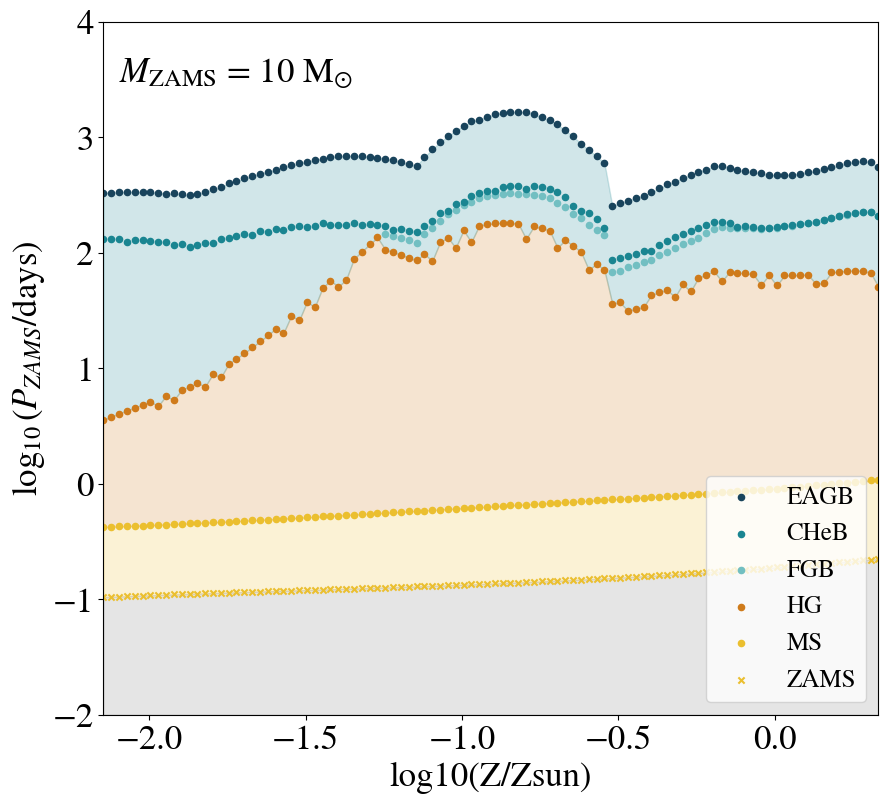

mass 40 3
[0.1804025  0.1816319  0.18284053 0.18402976 0.18520088 0.18635516
 0.18749378 0.18861792 0.18972868 0.19082716 0.19191442 0.19299149
 0.19405939 0.19511911 0.19617163 0.19721792 0.19825895 0.19929566
 0.20032903 0.20135998 0.20238949 0.20341851 0.204448   0.20547894
 0.20651231 0.20754911 0.20859035 0.20963706 0.21069029 0.21175111
 0.2128206  0.21389988 0.21499009 0.21609239 0.21720799 0.21833811
 0.21948402 0.220647   0.22182839 0.22302956 0.22425191 0.22549691
 0.22676602 0.2280608  0.22938283 0.23073372 0.23211516 0.23352887
 0.23497662 0.23646025 0.23798163 0.2395427  0.24114544 0.2427919
 0.24448418 0.24622443 0.24801488 0.24985779 0.2517555  0.25371038
 0.25572489 0.25780152 0.25994283 0.26215144 0.26442999 0.26678122
 0.26920788 0.2717128  0.27429881 0.27696883 0.27972579 0.28257266
 0.28551243 0.28854815 0.29168284 0.29491958 0.29826142 0.30171142
 0.30527266 0.30894817 0.31274097 0.31665405 0.32069036 0.32485279
 0.32914416 0.33356723 0.33812468 0.34281907 0.347652

/tmp/ipykernel_3394886/1671985918.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_FGB'][mi],mass, mass) ), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_3394886/1671985918.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_EAGB'][mi],mass, mass) ), c = "#19445c", s = 20, label = "EAGB")


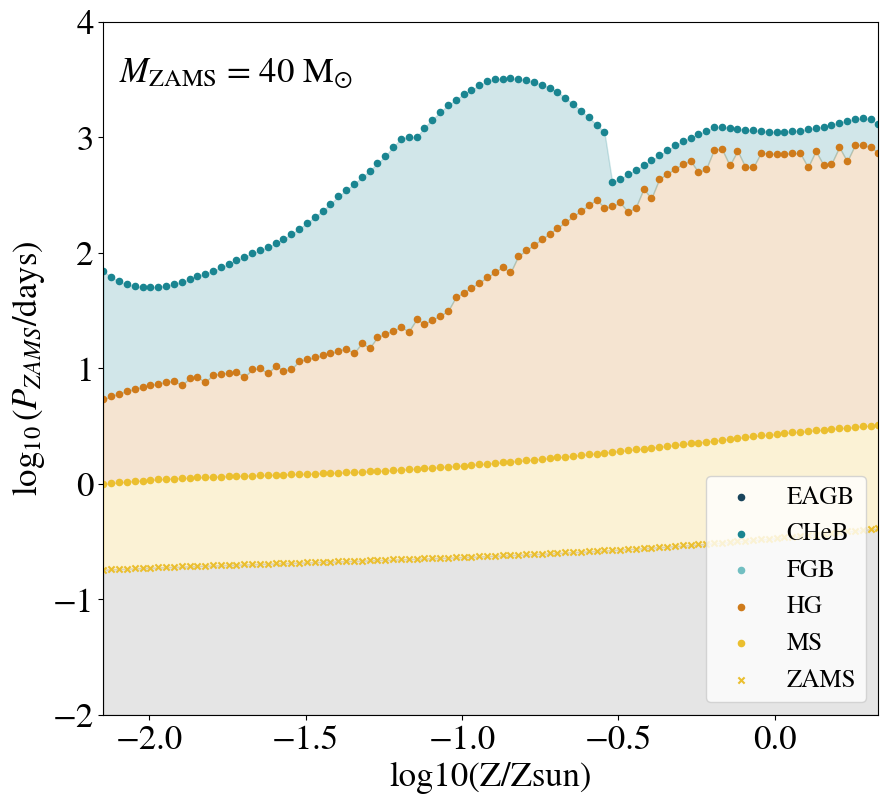

In [10]:


def plot_PZAMS_CaseABC(mass):
    """
    Plot the maximum radius for each type of star as a function of metallicity
    """
    mi = data['M0'].index(mass)
    print('mass', mass, mi)

    fig, ax = plt.subplots(figsize =(10,9))

    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 =-2, y2 = np.log10(Kepler3(data['R_ZAMS'][mi],mass, mass) ),  color = 'grey', alpha = 0.2)

    # R_ZAMS
    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['R_ZAMS'][mi],mass, mass) ), c = '#ebbf2f', s = 20, marker = 'x', label = 'ZAMS')

    # Case A is up to max MS
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(Kepler3(data['R_ZAMS'][mi],mass, mass) ), y2 = np.log10(Kepler3(data['maxR_MS'][mi],mass, mass) ),  color = '#ebbf2f', alpha = 0.2)

    #Case B is between MS and HG 
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(Kepler3(data['maxR_MS'][mi], mass, mass) ), y2 = np.log10(Kepler3(data['maxR_HG'][mi],mass, mass) ),  color = '#cf7b1b', alpha = 0.2)

    # Case C is beyond HG
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(Kepler3(data['maxR_HG'][mi],mass, mass) ), y2 = np.log10(Kepler3(data['maxRadii'][mi],mass, mass) ),  color = '#1a8591', alpha = 0.2)

    # Per types
    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_MS'][mi],mass, mass) ), c = '#ebbf2f', s = 20, label = 'MS')

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_HG'][mi],mass, mass) ), c = "#cf7b1b", s = 20, label = "HG")

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_FGB'][mi],mass, mass) ), c = "#72bfc2", s = 20, label = "FGB")

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_CHeB'][mi],mass, mass) ), c = "#1a8591", s = 20, label = "CHeB")

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_EAGB'][mi],mass, mass) ), c = "#19445c", s = 20, label = "EAGB")


    ax.text(0.02, 0.9, r'$M_{\rm ZAMS}$ = %s M$_{\odot}$'%(mass), transform=ax.transAxes, 
            ha = 'left', va = 'bottom', size = 25)

    # Plotvalues
    handles, labels = ax.get_legend_handles_labels() # Reverse legend order
    ax.legend(handles[::-1], labels[::-1], loc = 'lower right')
    plt.xlabel('log10(Z/Zsun)')
    plt.xlim(np.log10(1e-4/0.014), np.log10(0.03/0.014))
    plt.ylim(-2, 4)
    plt.ylabel('$\log_{10} (P_{ZAMS}$/days)')
    # plt.savefig(proj_dir + f'/plots/MaxR_Type_perZ_M{mass}_{var_name}_{version}.pdf',bbox_inches='tight')

    # Make a plot dir in the data dir if it doesnt exist yet
    if not os.path.exists(f'{root_out_dir}/plots/'):
        os.makedirs(f'{root_out_dir}/plots/')
    plt.savefig(f'../plots/PZAMS_Type_perZ_M{mass}.pdf',bbox_inches='tight')

    plt.show()


plot_PZAMS_CaseABC(10)
plot_PZAMS_CaseABC(40)